In [ ]:
# 환경 변수 로드 및 자동 리로드 설정
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

# Multi-Agent Research System

이 노트북은 이전의 모든 컴포넌트를 하나의 시스템으로 결합합니다.

전체 연구 흐름은 다음과 같습니다:

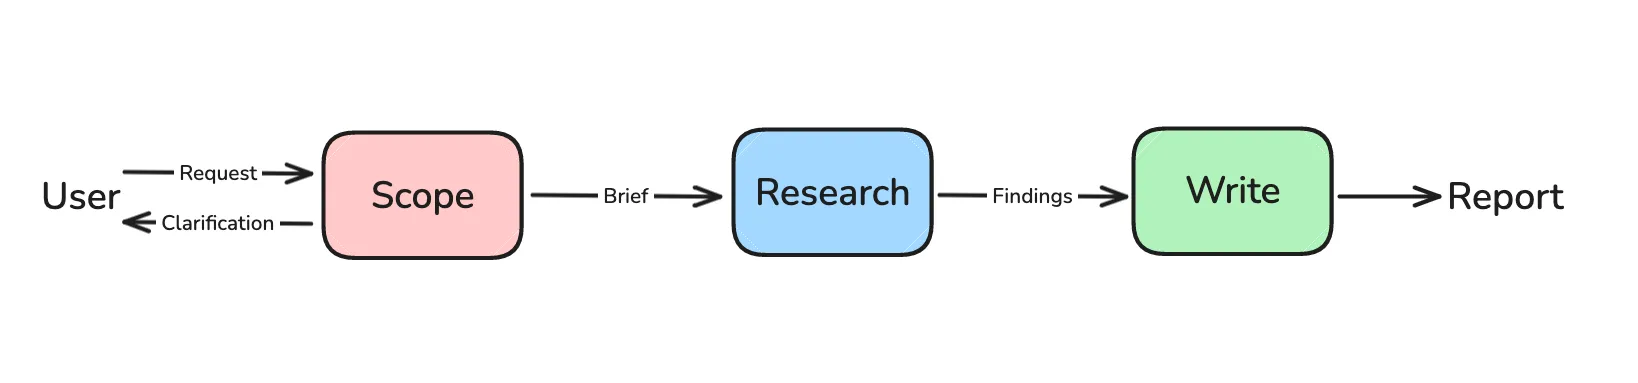

이전 노트북에서 연구 범위 설정(scoping)과 multi-agent 연구를 구축했습니다.

이제 최종 보고서 생성 단계를 추가하겠습니다.

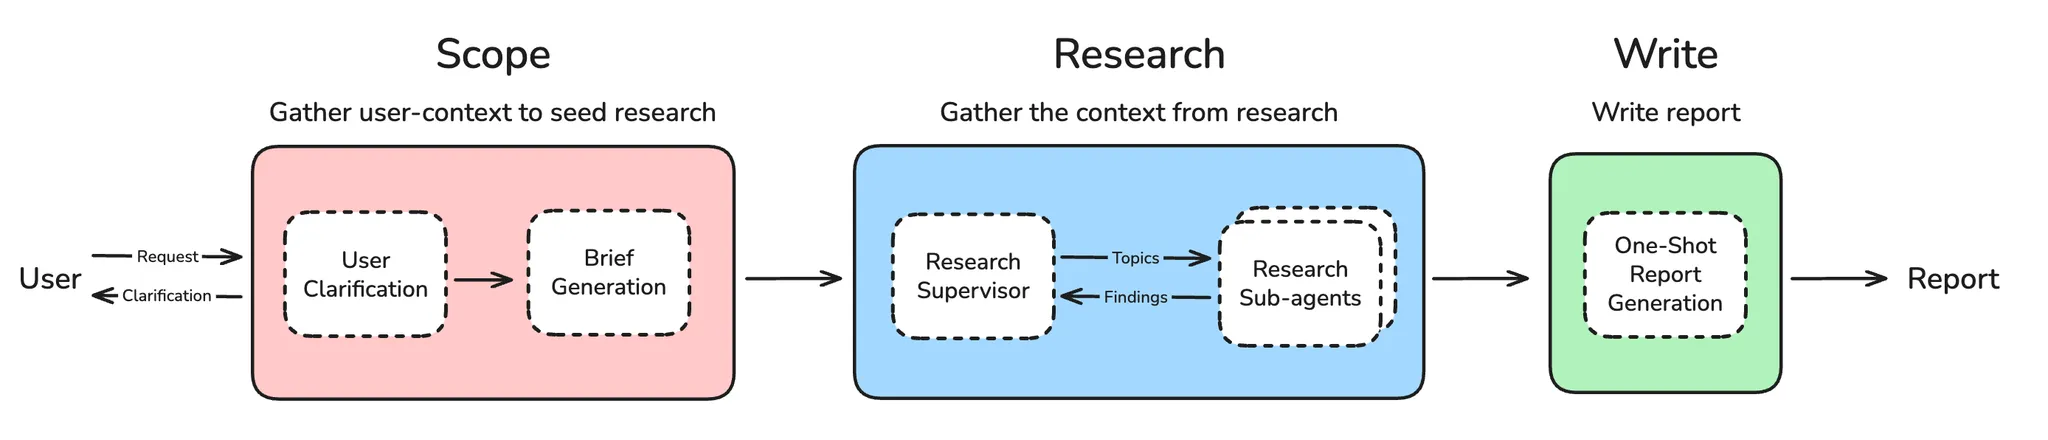

### Agent 

이미 구축한 컴포넌트를 간단히 재사용할 수 있습니다.

In [ ]:
%%writefile ../src/deep_research_from_scratch/research_agent_full.py

"""
Full Multi-Agent Research System

This module integrates all components of the research system:
- User clarification and scoping
- Research brief generation  
- Multi-agent research coordination
- Final report generation

The system orchestrates the complete research workflow from initial user
input through final report delivery.
"""

from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END

from deep_research_from_scratch.utils import get_today_str
from deep_research_from_scratch.prompts import final_report_generation_prompt
from deep_research_from_scratch.state_scope import AgentState, AgentInputState
from deep_research_from_scratch.research_agent_scope import clarify_with_user, write_research_brief
from deep_research_from_scratch.multi_agent_supervisor import supervisor_agent

# ===== Config =====

from langchain.chat_models import init_chat_model
writer_model = init_chat_model(model="openai:gpt-4.1", max_tokens=32000) # model="anthropic:claude-sonnet-4-20250514", max_tokens=64000

# ===== FINAL REPORT GENERATION =====

from deep_research_from_scratch.state_scope import AgentState

async def final_report_generation(state: AgentState):
    """
    Final report generation node.
    
    Synthesizes all research findings into a comprehensive final report
    """
    
    notes = state.get("notes", [])
    
    findings = "\n".join(notes)

    final_report_prompt = final_report_generation_prompt.format(
        research_brief=state.get("research_brief", ""),
        findings=findings,
        date=get_today_str()
    )
    
    final_report = await writer_model.ainvoke([HumanMessage(content=final_report_prompt)])
    
    return {
        "final_report": final_report.content, 
        "messages": ["Here is the final report: " + final_report.content],
    }

# ===== GRAPH CONSTRUCTION =====
# 전체 workflow 구축
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)

# workflow 노드 추가
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)
deep_researcher_builder.add_node("supervisor_subgraph", supervisor_agent)
deep_researcher_builder.add_node("final_report_generation", final_report_generation)

# workflow edge 추가
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", "supervisor_subgraph")
deep_researcher_builder.add_edge("supervisor_subgraph", "final_report_generation")
deep_researcher_builder.add_edge("final_report_generation", END)

# 전체 workflow 컴파일
agent = deep_researcher_builder.compile()

In [ ]:
# workflow 실행
from utils import format_messages
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from deep_research_from_scratch.research_agent_full import deep_researcher_builder

checkpointer = InMemorySaver()
full_agent = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(full_agent.get_graph(xray=True).draw_mermaid_png()))

LangGraph는 무한 루프를 방지하기 위해 기본적으로 25단계의 재귀 제한(recursion limit)을 가지고 있습니다. 반복적인 연구 라운드가 필요한 복잡한 연구 workflow의 경우 이 제한을 늘려야 합니다. [LangGraph의 troubleshooting 가이드](https://langchain-ai.github.io/langgraph/troubleshooting/errors/GRAPH_RECURSION_LIMIT/)에서 설명한 바와 같이, 재귀 제한은 graph의 모든 노드 실행을 카운트합니다. 우리의 multi-agent 연구 시스템에서:

- **Single Research Agent**: 도구 호출과 압축을 위해 8-12단계가 소요될 수 있음
- **Multi-Agent Supervisor**: 생성된 각 sub-agent가 추가 단계를 더함
- **Iterative Research**: Supervisor는 격차를 메우기 위해 여러 라운드의 연구를 수행할 수 있음
- **Full Workflow**: scoping, 연구 브리프 생성, supervision, 보고서 생성을 포함

다음을 수용하기 위해 재귀 제한을 **50**으로 설정합니다:
- 여러 연구 라운드가 필요한 복잡한 연구 주제
- 병렬 sub-agent 실행
- 많은 도구 호출이 있는 심층 연구
- scoping부터 최종 보고서까지의 완전한 workflow 실행

이를 통해 supervisor가 초기 조사 결과에 격차가 있을 때 반복적인 연구 라운드를 수행할 수 있어, 복잡한 연구 주제에 대한 포괄적인 커버리지를 보장합니다.

In [3]:
from langchain_core.messages import HumanMessage
thread = {"configurable": {"thread_id": "1", "recursion_limit": 50}}
result = await full_agent.ainvoke({"messages": [HumanMessage(content="Compare Gemini to OpenAI Deep Research agents.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Compare Gemini to OpenAI Deep Research agents.                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you clarify what you mean by 'OpenAI Deep Research agents'? Are you referring to a specific product,      │
│ research project, or a general class of AI agents developed by OpenAI?                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [4]:
result = await full_agent.ainvoke({"messages": [HumanMessage(content="Yes the specific Deep Research products.")]}, config=thread)

In [5]:
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Compare Gemini to OpenAI Deep Research agents.                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you clarify what you mean by 'OpenAI Deep Research agents'? Are you referring to a specific product,      │
│ research project, or a general class of AI agents developed by OpenAI?                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Yes the specific Deep Research products.                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Thank you for clarifying that you are referring to the specific Deep Research products from OpenAI. I           │
│ understand that you would like a comparison between Gemini and OpenAI's Deep Research agents. I will now begin  │
│ the research and prepare a comparative analysis based on the information provided.                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Here is the final report: # Comprehensive Comparison: Google Gemini vs. OpenAI Deep Research Agents (2025)      │
│                                                                                                                 │
│ ## Introduction                                                                                                 │
│                                                                                                                 │
│ This report provides a detailed, balanced comparison of Google’s Gemini AI suite and OpenAI’s Deep Research     │
│ agents. Both technologies represent state-of-the-art advancements in artificial intelligence but are designed   │
│ with distinct architectures, capabilities, use cases, and integration models. This analysis examines key        │
│ aspects such as core features, intended applications, underlying technologies, performance benchmarks,          │
│ integration options, and notable strengths and weaknesses, referencing the latest information and official      │
│ documentation as of August 2025.                                                                                │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ## Overview: Google Gemini                                                                                      │
│                                                                                                                 │
│ ### Core Capabilities                                                                                           │
│                                                                                                                 │
│ - **Multimodality**: Gemini supports native processing of text, images, video, audio, code, and PDF inputs, and │
│ can generate outputs in text, audio, and structured data formats. Recent iterations, such as Gemini 2.5 Deep    │
│ Think, can handle context windows exceeding 1 million tokens and output up to 192,000 tokens, enabling the      │
│ processing of vast and complex documents or media streams.                                                      │
│ - **Advanced Reasoning**: The “Deep Think” and Pro variants deploy parallel hypothesis testing and              │
│ reinforcement learning, excelling at coding, complex mathematical reasoning, multimodal understanding,          │
│ structured outputs, and function/tool calling.                                                                  │
│ - **Agentic Capabilities**: Gemini powers research agents and universal AI assistants (e.g., Project Astra,     │
│ Project Mariner), handling autonomous workflows like code debugging, real-time information retrieval, and       │
│ interactive web task completion.                                                                                │
│ - **Safety and Governance**: Gemini employs extensive safety measures, including red teaming (automated and     │
│ external), multi-tiered abuse monitoring, mitigations against sensitive domains (e.g., chemical/biological),    │
│ and oversight by Google DeepMind’s Responsibility and Safety Council. It adheres to ethical principles such as  │
│ minimization of bias and toxicity.                                                                              │
│                                                                                                                 │
│ ### Intended Use Cases                                                                                          │
│                                                        

In [6]:
from rich.markdown import Markdown
Markdown(result["final_report"])

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Comprehensive Comparison: Google Gemini vs. OpenAI Deep Research Agents (2025)                  ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


                                                   Introduction                                                    

This report provides a detailed, balanced comparison of Google’s Gemini AI suite and OpenAI’s Deep Research agents.
Both technologies represent state-of-the-art advancements in artificial intelligence but are designed with distinct
architectures, capabilities, use cases, and integration models. This analysis examines key aspects such as core    
features, intended applications, underlying technologies, performance benchmarks, integration options, and notable 
strengths and weaknesses, referencing the latest information and official documentation as of August 2025.         

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                              Overview: Google Gemini                                              

                                                 Core Capabilities                                                 

 • Multimodality: Gemini supports native processing of text, images, video, audio, code, and PDF inputs, and can   
   generate outputs in text, audio, and structured data formats. Recent iterations, such as Gemini 2.5 Deep Think, 
   can handle context windows exceeding 1 million tokens and output up to 192,000 tokens, enabling the processing  
   of vast and complex documents or media streams.                                                                 
 • Advanced Reasoning: The “Deep Think” and Pro variants deploy parallel hypothesis testing and reinforcement      
   learning, excelling at coding, complex mathematical reasoning, multimodal understanding, structured outputs, and
   function/tool calling.                                                                                          
 • Agentic Capabilities: Gemini powers research agents and universal AI assistants (e.g., Project Astra, Project   
   Mariner), handling autonomous workflows like code debugging, real-time information retrieval, and interactive   
   web task completion.                                                                                            
 • Safety and Governance: Gemini employs extensive safety measures, including red teaming (automated and external),
   multi-tiered abuse monitoring, mitigations against sensitive domains (e.g., chemical/biological), and oversight 
   by Google DeepMind’s Responsibility and Safety Council. It adheres to ethical principles such as minimization of
   bias and toxicity.                                                                                              

                                                Intended Use Cases                                                 

 • Complex knowledge work (e.g., scientific research, coding assistants, market analysis)                          
 • Large-scale document analysis, summarization, and synthesis                                                     
 • Content creation across text, image, video (e.g., AI-powered design, video generation with Veo, music with      
   Lyria)                                                                                                          
 • Autonomous agents for enterprise workflows (e.g., web research, spreadsheet automation, technical support,      
   creative design)                                                                                                
 • Integration into Google products and services: Workspace (Docs, Sheets, Slides), Pixel devices, Search, Ads,    
   Chrome, and Duet AI                         

추적 결과는 [여기](https://smith.langchain.com/public/86ebdc25-4595-4040-be1e-a8e30052786b/r)에서 확인할 수 있습니다.

### LangGraph Studio

이전에 했던 것처럼 LangGraph Studio를 사용하여 agent를 시각화할 수도 있습니다.

모든 노트북에서 `%%writefile`을 사용하여 `src/deep_research_from_scratch/`에 작성한 파일들이 애플리케이션을 위한 파일들을 생성합니다:

```
deep_research_from_scratch/
├── src/deep_research_from_scratch/
│   ├── state.py          # State 정의
│   ├── scope_research.py # Scoping workflow
│   ├── prompts.py        # Prompt 템플릿
│   └── ...
├── notebooks/            # 개발 노트북
├── pyproject.toml        # 의존성
└── langgraph.json        # LangGraph 설정
```

이 agent는 `langgraph.json` 파일에 추가되었으므로 드롭다운 메뉴에서 `research_agent_full`을 선택할 수 있습니다:

```
"research_agent_full": "./src/deep_research_from_scratch/research_agent_full.py:agent"
```

다음 명령어를 실행하여 studio를 시작하세요

```bash
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.11 langgraph dev --allow-blocking
```